This notebook shows how to load the mock data from BTK provided in `/data/mock.pkl`

# Load data

In [3]:
import pickle 
images, true, pred = pickle.load(open('../data/mock.pkl', 'rb'))
images.shape

(100, 6, 120, 120)

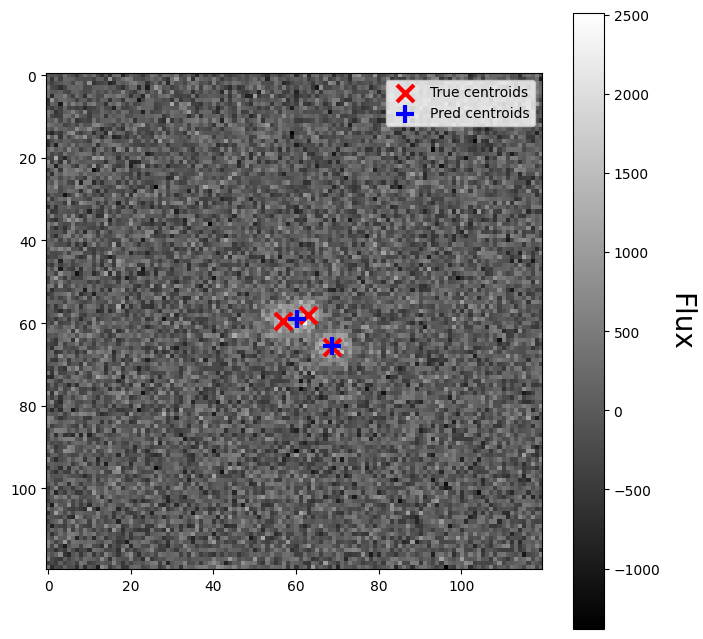

In [15]:
import matplotlib.pyplot as plt
import numpy as np
idx = np.random.randint(0, len(images))
band_idx = 2
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(images[idx,band_idx], cmap='gray')
ax.scatter(
    true[idx]["x"],
    true[idx]["y"],
    color="red",
    marker="x",
    label="True centroids",
    s=150,
    linewidth=3,
)
ax.scatter(
    pred[idx]["x"],
    pred[idx]["y"],
    color="blue",
    marker="+",
    label="Pred centroids",
    s=150,
    linewidth=3,
)

# add colorbar to axis
cbar = fig.colorbar(ax.images[0], ax=ax)
cbar.ax.set_ylabel("Flux", rotation=-90, va="bottom", fontsize=20)

# add legend to axis
ax.legend(loc="upper right")